# Welcome to the Flor Tutorial!

This tutorial consists of three parts, each of which builds on the previous.

# Part 1: Annotating and Versioning

A well-annotated experiment is easier to find and interpret, and a versioned experiment is easier to share and reproduce. In this part, we're going to show you how Flor can automate the annotating and versioning of alternatives you try in the process of training models.

## Prepare your environment before starting the activities.

We're going to start by importing Flor and letting it know the name of our notebook.

In [4]:
# Import Flor
import flor

# If the notebook name has not already been set, you are able to set the name in code. 
flor.setNotebookName('tutorial_1.ipynb')

## Sentiment Analaysis

First, we'll go through a short exercise to illustrate a common interactive model-training pattern. Here, we hope to demonstrate the value of versioning and provenance to motivate Flor. 

Let's get started. We're going to train a model to predict the sentiment polarity (positive, or negative) of English phrases. The model-training pipeline is fairly standard: we load a dataset, do some light preprocessing, do a train/test split, train the model, and then validate. 

In [ ]:
# Import standard libraries
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load the Data
movie_reviews = pd.read_json('data.json')

# Do light preprocessing
movie_reviews['rating'] = movie_reviews['rating'].map(lambda x: 0 if x < 5 else 1)

# Do train/test split
X_tr, X_te, y_tr, y_te = train_test_split(movie_reviews['text'], movie_reviews['rating'], 
                                          test_size=0.20, random_state=92)

# Vectorize the English sentences
vectorizer = TfidfVectorizer()
vectorizer.fit(X_tr)
X_tr = vectorizer.transform(X_tr)
X_te = vectorizer.transform(X_te)

# Fit the model              ##############
clf = RandomForestClassifier(n_estimators=5).fit(X_tr, y_tr)
                             ##############
y_pred = clf.predict(X_te)

# Validate the predictions
c = classification_report(y_te, y_pred)

print(c)

We see a report above. The precision and recall are hovering around 70%. From reading the code block, we also noticed that the Random Forest classifier was trained on just **5 estimators**, let's see what happens if we **increase the number of estimators to 7**.

In [ ]:
# Fit a new model            ###############
clf2 = RandomForestClassifier(n_estimators=7).fit(X_tr, y_tr)
                             ###############
y_pred = clf2.predict(X_te)

# Validate the predictions
score = clf2.score(X_te, y_te)
c = classification_report(y_te, y_pred)

print(c)

We see a minor improvement.

### Discussion of versioning and provenance tracking practices just demonstrated

In the exercise we just completed, we enforced some rudimentary forms of versioning and provenance. For versioning, rather than over-writing our model-fitting cell, we created a new cell, and rather than overwriting the `clf` variable, we created a new `clf2` variable. Moreover, if we save and version this notebook in a version control system such as Git, we might be able to restore the current version of this notebook, and fit a very similar model to the one we just derived. Given these practices, if we break something, we can rollback. As for provenance, the plaintext accompanying the cells (as well as the in-line comments) will allow a human to interpret causal effects: the only thing we changed was the number of estimators, and we changed the number of estimators from 5 to 7, which improved the quality metrics of the model. A human analyst with this information would therefore be able to answer questions such as, what data did you read, and where did you read it from? And, what model did you fit?

Despite some of these benefits, this rudimentary form of versioning and provenance tracking doesn't scale well. An analyst rushing to meet a deadline may over-write the same cell rather than make a copy, or forget to commit to Git after any change to the notebook: this would compromise our quality of versioning. Moreover, it's easy to see that as the complexity of the model-training pipeline increases from a few dozen lines of code to the thousands, and the model-training pipeline involves some distribution of code and data, and use of heterogeneous and complex infrastructure, manual human inspection of source code will be an inadequate substitute for a provenance management system. 

## Sentiment Analysis in Flor

Thus motivated, two of the many useful things Flor supports is automatic versioning of experiments and provenance tracking. We'll start by showing these two features of Flor -- emphasizing how easy it is to wrap a pre-existing pipeline (namely, the one we ran before) in Flor. Here, we hope to convince you to use Flor rather than implement versioning and provenance tracking yourself.

### BEGIN FLOR EXPERIMENT

In the cell below, we've copied the model-training pipeline from before (with 5 estimators).

We had to make 2 changes to wrap our model-training pipeline in Flor:
1. Copy and paste the code into a decorated function
2. Return the value(s) we want Flor to track

We highlight the differences in-line using `###`.

             precision    recall  f1-score   support

          0       0.70      0.71      0.71      5024
          1       0.70      0.70      0.70      4976

avg / total       0.70      0.70      0.70     10000



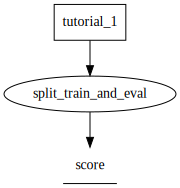

In [2]:
###################################
@flor.track_action('risecamp_demo')
def split_train_and_eval(**kwargs):
###################################
    import pandas as pd

    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report
    movie_reviews = pd.read_json('data.json')
    movie_reviews['rating'] = movie_reviews['rating'].map(lambda x: 0 if x < 5 else 1)

    X_tr, X_te, y_tr, y_te = train_test_split(movie_reviews['text'], movie_reviews['rating'], 
                                              test_size=0.20, random_state=92)

    vectorizer = TfidfVectorizer()
    vectorizer.fit(X_tr)
    X_tr = vectorizer.transform(X_tr)
    X_te = vectorizer.transform(X_te)
    clf = RandomForestClassifier(n_estimators=5).fit(X_tr, y_tr)
    
    y_pred = clf.predict(X_te)

    score = clf.score(X_te, y_te)
    c = classification_report(y_te, y_pred)

    print(c)
    
    #######################
    return {'score': score}
    #######################

# This is how we run the pipeline
split_train_and_eval()

As before, and as expected, we see that the score is hovering around 70%. Underneath, we can see the Flor Plan of our `risecamp_demo` experiment. We read it as follows: the function `split_train_and_eval` defined in the tutorial artifact (`tutorial_1.ipynb`) is run to produce a `score`. Despite its simplicity and coarse granularity, we can use this diagram to answer provenance questions about the `score`.

Next, let's take a look at what Flor has captured so far from our experiment execution:

In [5]:
flor.Experiment('risecamp_demo').summarize()

,label,score,tutorial_1
0,2018-10-08_02-37-09,0.704,tutorial_1_140569923345264.ipynb


Here, the `label` is just the execution timestamp. The values in the columns `score` and `tutorial_1` are complementary information to the Flor Plan diagram. From this, we see that our Jupyter notebook was automatically versioned, and all of the relevant artifacts and hyperparameters were associated with the execution label. 

***Important instructions*** Now, you will jump to **BEGIN FLOR EXPERIMENT** (scroll up), and modify the cell underneath that label. Change the number of estimators from 5 to 7 (Line 21) and re-run the cells.

Here, you should see that what would have been a destructive change without Flor (over-writing a cell and re-running it), is properly handled with Flor. Flor automatically preserves versions and tracks provenance.

## Finer granularity tracking in Flor

So far, we've seen how to wrap a model-training pipeline in Flor with just 3 lines of code. This coarse-grained wrapping helped us capture some meta-data about the model, and version the code we used to train it. Next, we're going to show how to do a hyper-parameter sweep (where we re-run the pipeline once for every possible configuration), and at the same time demonstrate how exposing the hyper-parameters of the model helps us capture more meta-data. As before, the changes are minimal, and highlighted in `###`.

In [ ]:
@flor.track_action('risecamp_demo')
                         ############  #########
def split_train_and_eval(n_estimators, max_depth, **kwargs):
                         ############  #########
    import pandas as pd

    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report
    movie_reviews = pd.read_json('data.json')
    movie_reviews['rating'] = movie_reviews['rating'].map(lambda x: 0 if x < 5 else 1)

    X_tr, X_te, y_tr, y_te = train_test_split(movie_reviews['text'], movie_reviews['rating'], 
                                              test_size=0.20, random_state=92)

    vectorizer = TfidfVectorizer()
    vectorizer.fit(X_tr)
    X_tr = vectorizer.transform(X_tr)
    X_te = vectorizer.transform(X_te)         ############            #########
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth).fit(X_tr, y_tr)
                                              ############            #########
    y_pred = clf.predict(X_te)

    score = clf.score(X_te, y_te)
    c = classification_report(y_te, y_pred)

    print(c)
    
    return {'score': score}
    
# This is how we run the pipeline
split_train_and_eval(7, [10, 100])

Notice that the model-training pipeline ran twice, once per value in `max_depth`. To denote this, there is a rectangle with `2x` at its top-center.

Now, let's summarize the experiment to see what we've done so far. You should see a table with 4 rows. The table has many cells with `NaN` because we've introduced new hyper-parameters that were not available in previous versions of the experiment.

In [ ]:
flor.Experiment('risecamp_demo').summarize()

## Concluding Remarks

Now that you've 